In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

#Loading the Data

In [ ]:
from google.colab import files
uploaded = files.upload()
import pandas as pd
import io


Saving Encoded_Gas_price_By_State.xlsx to Encoded_Gas_price_By_State (1).xlsx


In [ ]:
df = pd.read_excel(io.BytesIO(uploaded['Encoded_Gas_price_By_State (1).xlsx']))
df.head()


,State,Region,Brand,Price,Distance_From_MajorCity,Population_in_Region,Average_Fuel_Price,State_Tax,Median_Annual_Income,Reputation_Score,Brand_encoded,Region_encoded
0,Alabama,Mobile,Citgo,2.41,168.0,182595,2.76,0.312,41350,5,38,144
1,Alabama,Leeds,Murphy USA,2.43,101.0,12416,2.76,0.312,41350,6,109,120
2,Alabama,Moody,Love's Travel Stop,2.43,103.0,13595,2.76,0.312,41350,6,90,149
3,Alabama,Odenville,Valero,2.43,111.0,5352,2.76,0.312,41350,7,168,170
4,Alabama,Leeds,Raceway,2.43,101.0,12416,2.76,0.312,41350,5,132,120


#Checking for Null Values

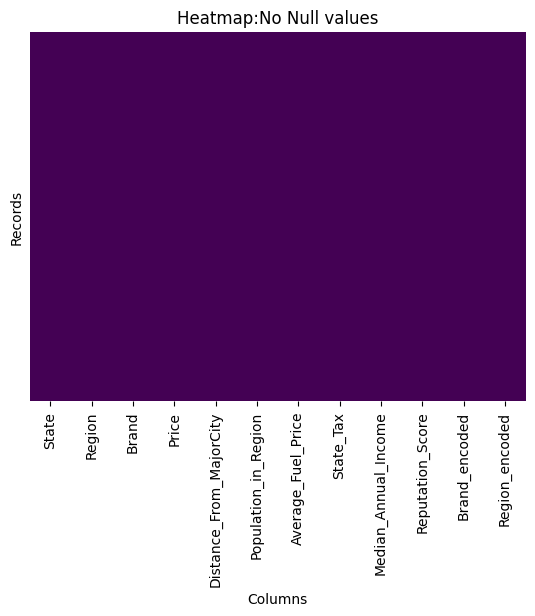

In [ ]:
sns.heatmap(df.isna(), cbar= False, cmap='viridis', yticklabels=False)
plt.title('Heatmap:No Null values')
plt.xlabel('Columns')
plt.ylabel('Records')
plt.show()

#Data Visualization

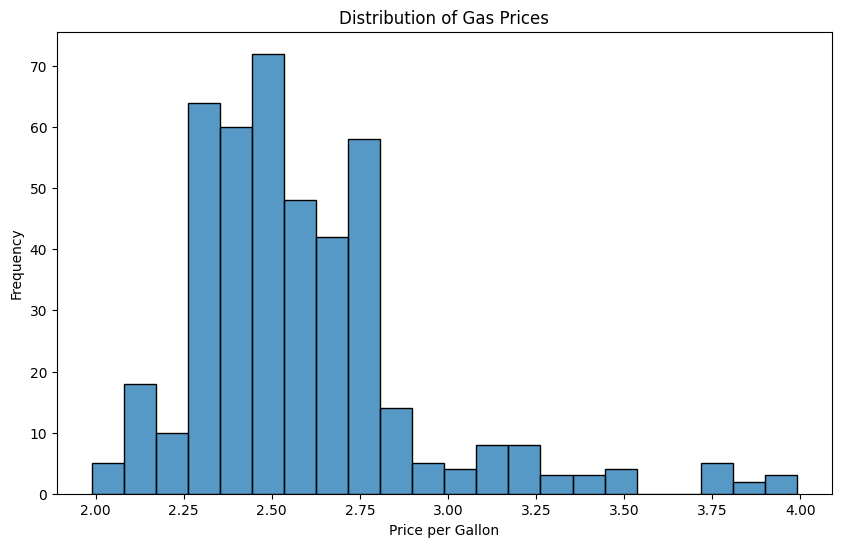

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=False)
plt.title('Distribution of Gas Prices')
plt.xlabel('Price per Gallon')
plt.ylabel('Frequency')
plt.show()


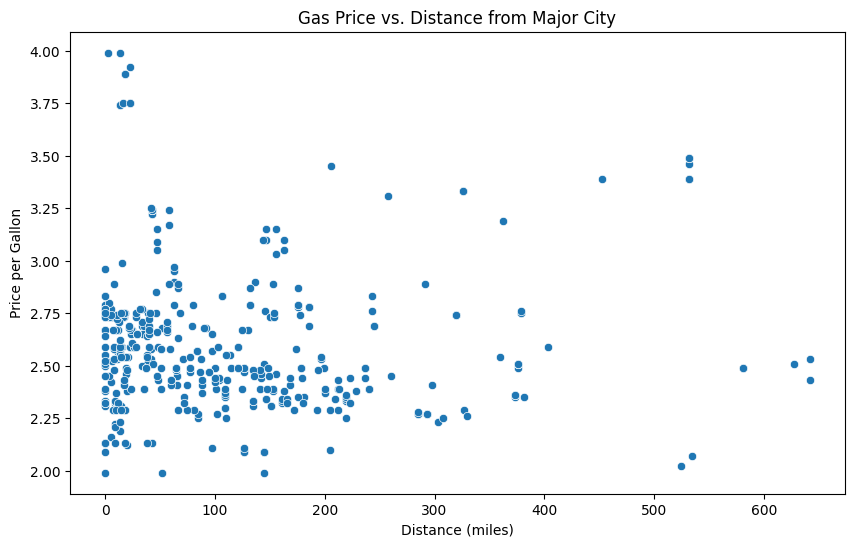

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Distance_From_MajorCity', y='Price')
plt.title('Gas Price vs. Distance from Major City')
plt.xlabel('Distance (miles)')
plt.ylabel('Price per Gallon')
plt.show()


In [ ]:
df_new = df.select_dtypes(exclude=['object'])
df_new.head()

,Price,Distance_From_MajorCity,Population_in_Region,Average_Fuel_Price,State_Tax,Median_Annual_Income,Reputation_Score,Brand_encoded,Region_encoded
0,2.41,168.0,182595,2.76,0.312,41350,5,38,144
1,2.43,101.0,12416,2.76,0.312,41350,6,109,120
2,2.43,103.0,13595,2.76,0.312,41350,6,90,149
3,2.43,111.0,5352,2.76,0.312,41350,7,168,170
4,2.43,101.0,12416,2.76,0.312,41350,5,132,120


#Correlation Matrix

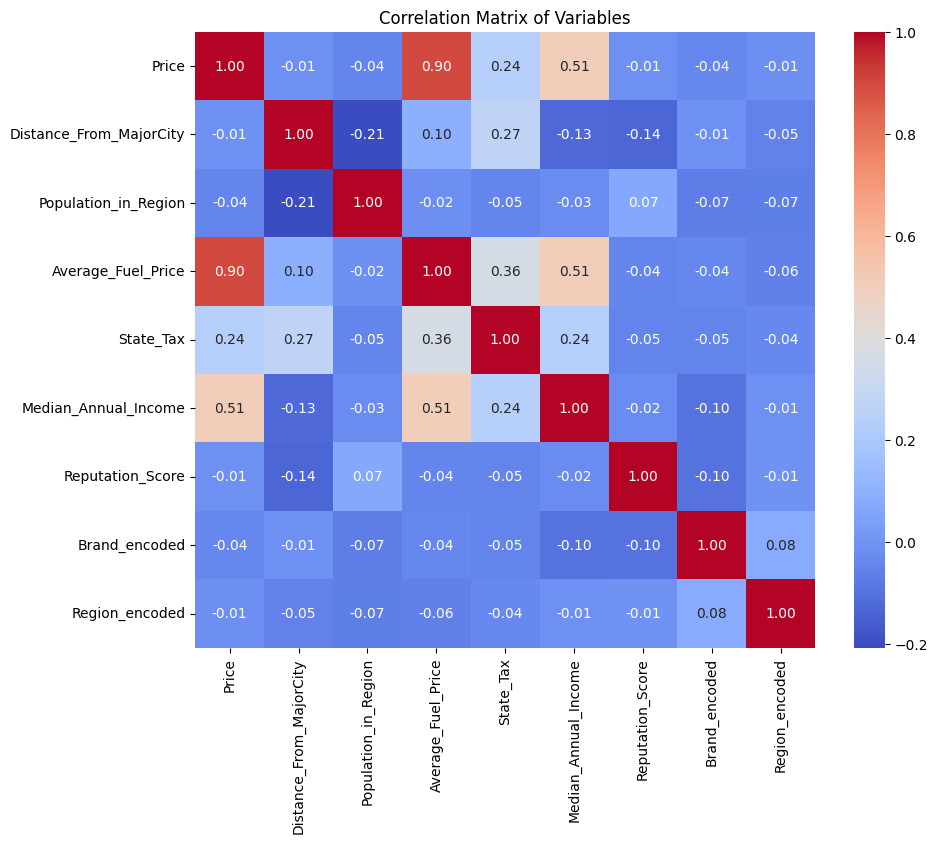

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_new.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Variables')
plt.show()

#Pairplot

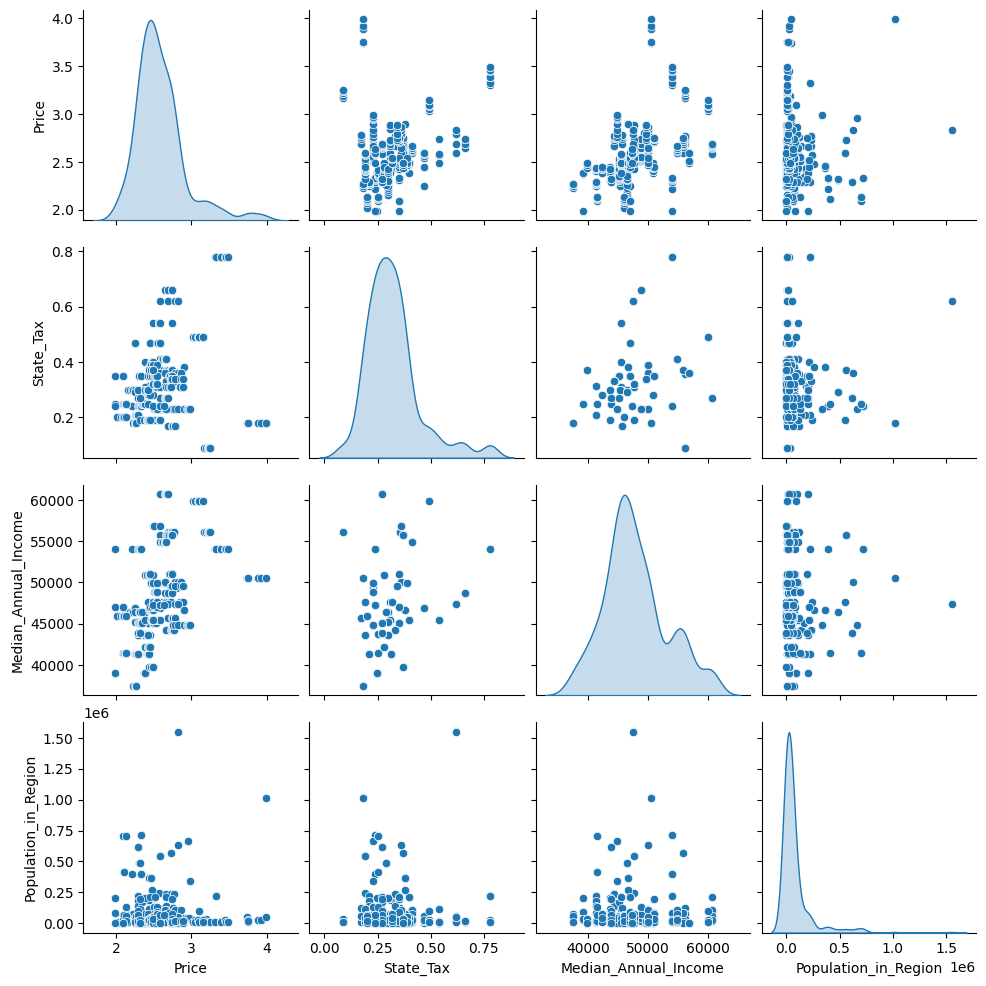

In [ ]:
sns.pairplot(df[['Price', 'State_Tax', 'Median_Annual_Income', 'Population_in_Region']], diag_kind='kde')
plt.show()


#Linear Regression Analysis

In [ ]:
X = df_new.drop('Price', axis=1)
y = df_new['Price']

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaled_data = sc.fit_transform(X)
X_scaled = pd.DataFrame(scaled_data, columns=X.columns)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)

In [ ]:
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

class MultipleLinearRegressionStatsModel:
    def __init__(self, feature_names, target_name, feature_selection=False):
        self.feature_names = feature_names
        self.target_name = target_name
        self.X_columns = None
        self.model = None
        self.results = None
        self.feature_selection = feature_selection
        self.selected_features = feature_names

    def fit(self, X, y):
        # Feature selection
        if self.feature_selection:
            sfs = SequentialFeatureSelector(estimator = LinearRegression(), forward= True, k_features ='best', scoring='r2', cv=5, n_jobs=-1)
            sfs.fit(X, y)
            selected_features=list(sfs.k_feature_names_)
        else:
            selected_features = self.feature_names

        # Fit the linear regression model using statsmodels
        X = sm.add_constant(X[selected_features])
        model = sm.OLS(y, X)
        self.results = model.fit()
        self.model = model
        self.selected_features = selected_features

    def predict(self, X_data):
        # Add constant term to new data and make predictions
        X_data = sm.add_constant(X_data)
        return self.results.predict(X_data)

    def get_summary(self):
        summary_data = {
            'Dep. Variable': self.target_name,
            'No. Observations': len(self.results.model.endog),
            'Model': 'OLS',
            'Df Residuals': self.results.df_resid,
            'R-squared': self.results.rsquared,
            'Adj. R-squared': self.results.rsquared_adj,
            'F-statistic': self.results.fvalue,
            'Prob (F-statistic)': self.results.f_pvalue,
            'Log-Likelihood': self.results.llf,
            'AIC': self.results.aic,
            'BIC': self.results.bic,
            'Standard Error of Estimate': self.results.mse_resid**0.5
        }
        summary = pd.DataFrame([summary_data])
        return summary

    def get_coef_summary(self):
        coef_summary_data = {
            'Coefficient Value': self.results.params,
            'Standard Error': self.results.bse,
            't-value': self.results.tvalues,
            'P>|t|': np.round(self.results.pvalues,4)
        }
        coef_summary = pd.DataFrame(coef_summary_data)
        return coef_summary

In [ ]:
reg_model = MultipleLinearRegressionStatsModel(feature_names=X.columns, target_name='Price',feature_selection=True)


# Fit the model using the training data
reg_model.fit(X_train, y_train)

# Get the model summary and coefficient summary
model_summary = reg_model.get_summary()
coef_summary = reg_model.get_coef_summary()

# Print the model summary
print("Multiple Linear Regression Summary:")
print(model_summary.transpose())

# Print the coefficient summary
print("\nRegression Coefficients Summary:")
coef_summary

Multiple Linear Regression Summary:
                                     0
Dep. Variable                    Price
No. Observations                   305
Model                              OLS
Df Residuals                     301.0
R-squared                     0.828842
Adj. R-squared                0.827136
F-statistic                 485.870353
Prob (F-statistic)                 0.0
Log-Likelihood              171.698867
AIC                        -335.397734
BIC                        -320.516486
Standard Error of Estimate    0.138722

Regression Coefficients Summary:


,Coefficient Value,Standard Error,t-value,P>|t|
const,2.583660,0.007944,325.252559,0.0000
Average_Fuel_Price,0.295889,0.009184,32.218013,0.0000
State_Tax,-0.031042,0.008472,-3.664160,0.0003
Median_Annual_Income,0.027309,0.009085,3.005937,0.0029


In [ ]:
reg_model.selected_features

['Average_Fuel_Price', 'State_Tax', 'Median_Annual_Income']

In [ ]:
y_pred = reg_model.predict(X_test[reg_model.selected_features])

result = pd.DataFrame({'Predicted': y_pred, 'Actual': y_test,'Residual': y_test - y_pred})
print(result.head(20))

     Predicted  Actual  Residual
395   2.633710    2.89  0.256290
78    2.607538    2.31 -0.297538
278   2.448146    2.32 -0.128146
305   2.486716    2.55  0.063284
325   2.941845    2.78 -0.161845
289   2.694635    2.51 -0.184635
218   2.263215    2.23 -0.033215
82    2.607538    2.49 -0.117538
432   2.575019    2.58  0.004981
402   2.502855    2.49 -0.012855
290   2.694635    2.51 -0.184635
75    2.580954    2.77  0.189046
225   2.263215    2.27  0.006785
394   2.633710    2.89  0.256290
155   2.398743    2.37 -0.028743
76    2.580954    2.79  0.209046
431   2.575019    2.58  0.004981
192   2.651793    2.67  0.018207
73    2.580954    2.75  0.169046
153   2.398743    2.35 -0.048743


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# MAE as a percentage of the median spending
mae/y.median()*100
print(f"MAE as a percentage of the median spending: {mae/y_train.median()*100:.2f}%")

Mean Squared Error (MSE): 0.02
Root Mean Squared Error (RMSE): 0.14
Mean Absolute Error (MAE): 0.11
MAE as a percentage of the median spending: 4.45%


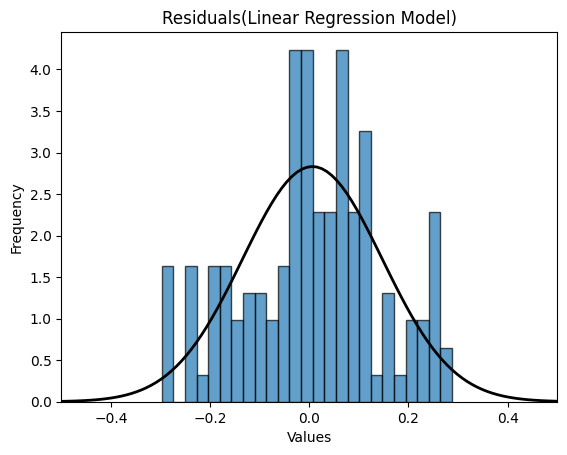

In [ ]:
from scipy.stats import norm

all_residuals = y_test - y_pred
mean, std = np.mean(all_residuals), np.std(all_residuals)

fig, ax = plt.subplots()
ax.hist(all_residuals, bins=25, edgecolor='black', alpha=0.7, density=True)

ax.set_title('Residuals(Linear Regression Model)')
ax.set_xlabel('Values')
ax.set_ylabel('Frequency')
ax.set_xlim(-0.5,0.5)

x = np.linspace(-0.5, 0.5, 100)
pdf = norm.pdf(x, mean, std)
ax.plot(x, pdf, 'k', linewidth=2, label='Normal distribution')

plt.show()

#Principal Component Analysis

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train_scaled)
pcaSummary_df = pd.DataFrame({'Explained Variance': pca.explained_variance_,
                           'Proportion of explained variance': pca.explained_variance_ratio_,
                           'Cumulative proportion': np.cumsum(pca.explained_variance_ratio_)})
pcaSummary_df = pcaSummary_df.transpose()
pcaSummary_df.columns = [f'PC{i}' for i in range(1, len(pcaSummary_df.columns) + 1)]
pcaSummary_df.round(4)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Explained Variance,1.7379,1.3970,1.1192,0.9906,0.9004,0.8208,0.6215,0.4389
Proportion of explained variance,0.2165,0.1740,0.1394,0.1234,0.1122,0.1023,0.0774,0.0547
Cumulative proportion,0.2165,0.3906,0.5300,0.6534,0.7656,0.8679,0.9453,1.0000


In [ ]:
PC_train = pd.DataFrame(pca.transform(X_train_scaled)[:,:6], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5','PC6'])
PC_test = pd.DataFrame(pca.transform(X_test_scaled)[:,:6], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5','PC6'])


In [ ]:
from sklearn.linear_model import LinearRegression
sklr = LinearRegression()
sklr.fit(PC_train, y_train)

# print coefficients
print('intercept ', sklr.intercept_)
print(pd.DataFrame({'Predictor': PC_train.columns, 'coefficient': sklr.coef_}))

intercept  2.5842295081967213
  Predictor  coefficient
0       PC1     0.177418
1       PC2    -0.052801
2       PC3     0.063551
3       PC4    -0.002342
4       PC5    -0.011248
5       PC6     0.018834


In [ ]:
from sklearn.metrics import r2_score

y_pred = sklr.predict(PC_train)
print(f'R^2 : {r2_score(y_train, y_pred):.4f}')

R^2 : 0.5707


In [ ]:
y_pred = sklr.predict(PC_test)

# Calculate MSE
mse_pc = mean_squared_error(y_test, y_pred)

# Calculate RMSE
rmse_pc = np.sqrt(mse_pc)
print(f"Root Mean Squared Error (RMSE): {rmse_pc:.4f}")

# Calculate MAE
mae_pc = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae_pc:.4f}")

Root Mean Squared Error (RMSE): 0.1921
Mean Absolute Error (MAE): 0.1410


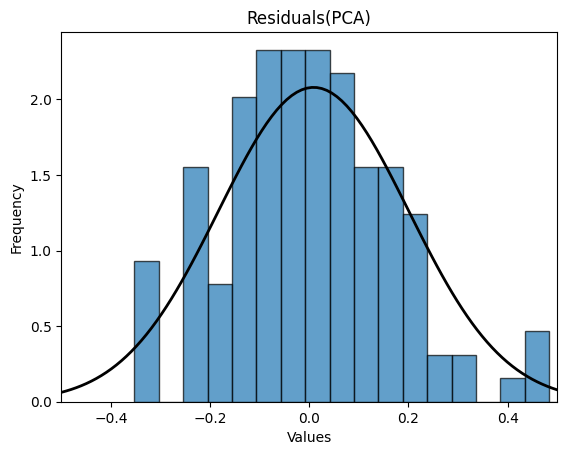

In [ ]:

from scipy.stats import norm

all_residuals = y_test - y_pred
mean, std = np.mean(all_residuals), np.std(all_residuals)

fig, ax = plt.subplots()
ax.hist(all_residuals, bins=25, edgecolor='black', alpha=0.7, density=True)

# Customize labels and title
ax.set_title('Residuals(PCA)')
ax.set_xlabel('Values')
ax.set_ylabel('Frequency')

ax.set_xlim(-0.5, 0.5)

x = np.linspace(-0.5, 0.5, 100)
pdf = norm.pdf(x, mean, std)
ax.plot(x, pdf, 'k', linewidth=2, label='Normal distribution')

plt.show()

#RandomForest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
random_forest_model = RandomForestRegressor(n_estimators=500, random_state=42)
random_forest_model.fit(X_train, y_train)

# Predict on training and testing sets
y_pred = random_forest_model.predict(X_test)

# Calculate MSE
mse_rf = mean_squared_error(y_test, y_pred)

# Calculate RMSE
rmse_rf = np.sqrt(mse_rf)
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.4f}")

# Calculate MAE
mae_rf = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")

Root Mean Squared Error (RMSE): 0.0812
Mean Absolute Error (MAE): 0.0520


#Comparing the regression models

In [ ]:
results_summary = {
'Model': ['Forward Selection LR', 'PCA+LR', 'Random Forest Regression'],
'RMSE': [rmse, rmse_pc, rmse_rf],
'MAE': [mae, mae_pc, mae_rf]
}
results_df = pd.DataFrame(results_summary)
print(results_df)

                      Model      RMSE       MAE
0      Forward Selection LR  0.141032  0.111617
1                    PCA+LR  0.192084  0.140975
2  Random Forest Regression  0.081214  0.052016


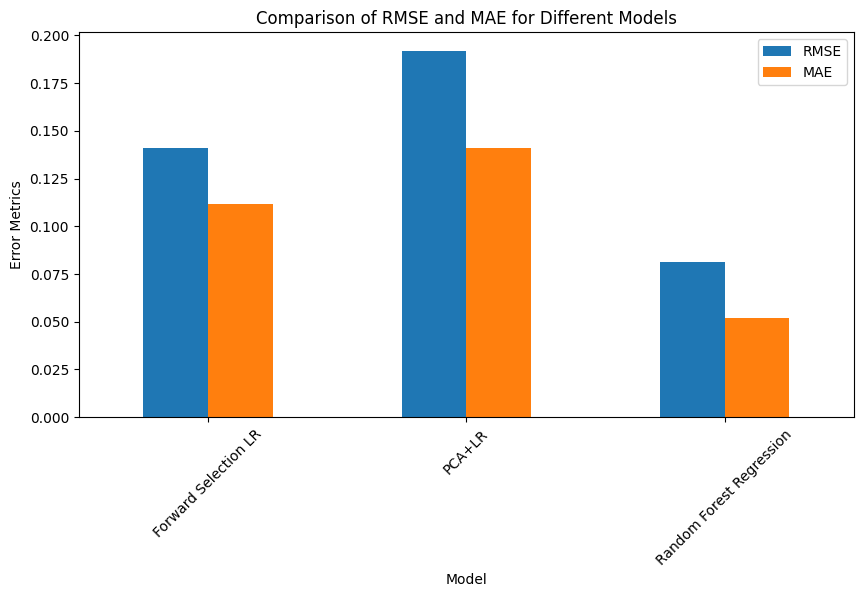

In [ ]:
fig, ax = plt.subplots()
results_df.plot(kind='bar', ax=ax, x='Model', y=['RMSE', 'MAE'], figsize=(10, 5))
ax.set_ylabel('Error Metrics')
ax.set_title('Comparison of RMSE and MAE for Different Models')
ax.set_xticklabels(results_df['Model'], rotation=45)

plt.show()

#Random Forest Classifier

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Assuming df is your original DataFrame
print(df_new.dtypes)  # Check data types
print(df_new.isnull().sum())  # Check for missing values


# Setup X and y
X = df_new.drop(['Reputation_Score','Brand_encoded','Region_encoded'], axis=1)
y = df_new['Reputation_Score']  # Ensure this is appropriate for your model type

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Price                      float64
Distance_From_MajorCity    float64
Population_in_Region         int64
Average_Fuel_Price         float64
State_Tax                  float64
Median_Annual_Income         int64
Reputation_Score             int64
Brand_encoded                int64
Region_encoded               int64
dtype: object
Price                      0
Distance_From_MajorCity    0
Population_in_Region       0
Average_Fuel_Price         0
State_Tax                  0
Median_Annual_Income       0
Reputation_Score           0
Brand_encoded              0
Region_encoded             0
dtype: int64


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit RandomForest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.3977272727272727


#Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

# Selecting the relevant features for clustering
scaler = MinMaxScaler()
X =df[['Price','Distance_From_MajorCity',	'Population_in_Region',	'Average_Fuel_Price','State_Tax',	'Median_Annual_Income',	'Reputation_Score']]
X = scaler.fit_transform(X)

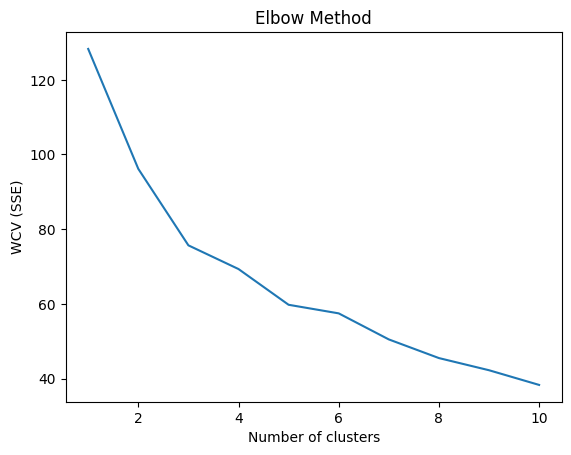

In [ ]:
WCV = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, max_iter=300, n_init="auto", random_state=0)
    kmeans.fit(X)
    WCV.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(range(1, 11), WCV)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCV (SSE)') # within cluster variation (sum of squares)
plt.show()

In [ ]:
# Using silhouette score to find the optimal number of clusters
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i,  n_init='auto', random_state=0).fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Silhouette Score for {i} clusters: {score}")

Silhouette Score for 2 clusters: 0.26318274291331156
Silhouette Score for 3 clusters: 0.2881628298902565
Silhouette Score for 4 clusters: 0.2285282673928484
Silhouette Score for 5 clusters: 0.24797130930707037
Silhouette Score for 6 clusters: 0.19770804047564625
Silhouette Score for 7 clusters: 0.21604283790833229
Silhouette Score for 8 clusters: 0.2391342717921105
Silhouette Score for 9 clusters: 0.25063321679265316
Silhouette Score for 10 clusters: 0.2596657556647596


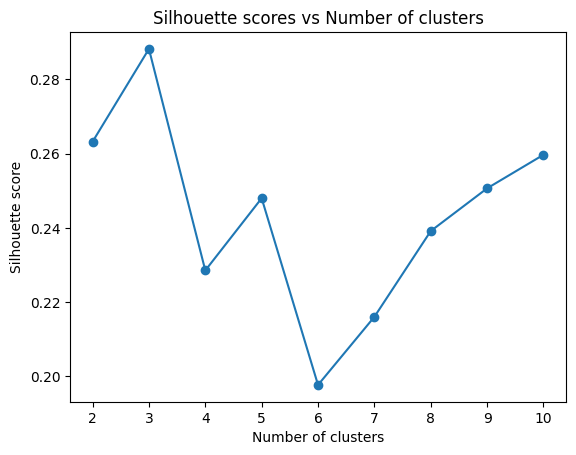

In [ ]:
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette scores vs Number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [ ]:
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"The optimal number of clusters is: {optimal_clusters}")

The optimal number of clusters is: 3


In [ ]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, n_init="auto", random_state=0)
cluster_labels = kmeans.fit_predict(X)

In [ ]:
df_extended =df.copy()
df_extended['Cluster'] = cluster_labels
df_extended

,State,Region,Brand,Price,Distance_From_MajorCity,Population_in_Region,Average_Fuel_Price,State_Tax,Median_Annual_Income,Reputation_Score,Brand_encoded,Region_encoded,Cluster
0,Alabama,Mobile,Citgo,2.41,168.0,182595,2.76,0.312,41350,5,38,144,0
1,Alabama,Leeds,Murphy USA,2.43,101.0,12416,2.76,0.312,41350,6,109,120,0
2,Alabama,Moody,Love's Travel Stop,2.43,103.0,13595,2.76,0.312,41350,6,90,149,0
3,Alabama,Odenville,Valero,2.43,111.0,5352,2.76,0.312,41350,7,168,170,1
4,Alabama,Leeds,Raceway,2.43,101.0,12416,2.76,0.312,41350,5,132,120,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,Wyoming,Laramie,Maverik,2.58,50.6,32152,3.02,0.240,47250,6,96,113,1
432,Wyoming,Laramie,Pilot,2.58,50.6,32152,3.02,0.240,47250,6,120,113,1
433,Wyoming,Buford,PhinDeli,2.59,27.8,0,3.02,0.240,47250,4,119,36,3
434,Wyoming,Cheyenne,Walmart,2.59,0.0,65141,3.02,0.240,47250,6,173,45,1


In [ ]:
cluster_counts = df_extended['Cluster'].value_counts().sort_index()
cluster_counts

,count
Cluster,
0,164
1,138
2,23
3,111


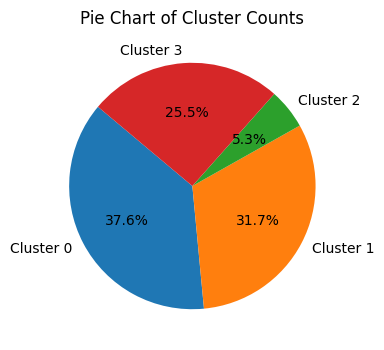

In [ ]:
# Create a pie chart
cluster_labels = [f'Cluster {i}' for i in cluster_counts.index]

plt.figure(figsize=(4, 4))
plt.pie(cluster_counts, labels = cluster_labels, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of Cluster Counts')
plt.show()

In [ ]:
cluster_means= df_extended.groupby('Cluster')[['Price','Distance_From_MajorCity',	'Population_in_Region',	'Average_Fuel_Price','State_Tax',	'Median_Annual_Income',	'Reputation_Score']].mean()
cluster_means

,Price,Distance_From_MajorCity,Population_in_Region,Average_Fuel_Price,State_Tax,Median_Annual_Income,Reputation_Score
Cluster,,,,,,,
0,2.371037,143.770488,80033.396341,2.793537,0.284634,43757.804878,4.981707
1,2.618406,73.608188,97532.934783,3.077536,0.315855,48573.333333,7.304348
2,2.969565,422.113043,34551.652174,3.726522,0.639130,50096.956522,4.565217
3,2.782072,64.952252,64911.585586,3.277027,0.314450,52503.513514,4.342342


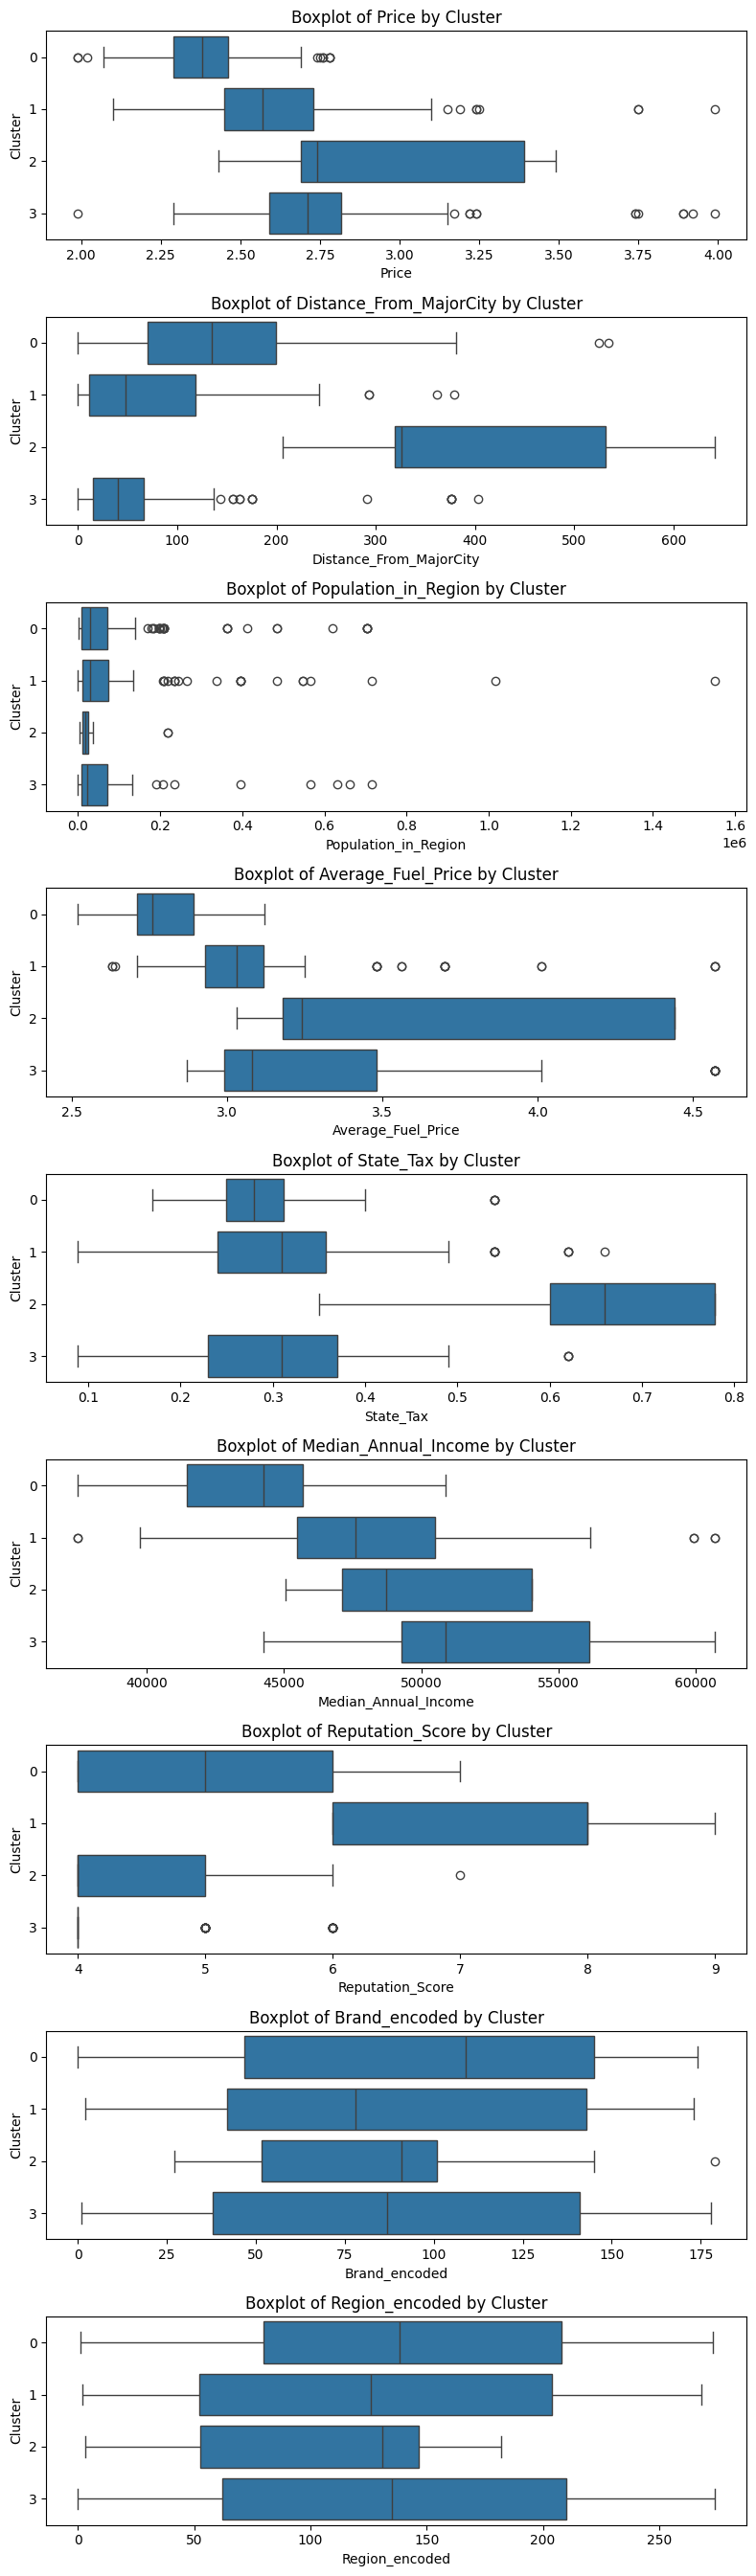

In [ ]:
numeric_vars =['Price'	,'Distance_From_MajorCity','Population_in_Region','Average_Fuel_Price'	,'State_Tax'	,'Median_Annual_Income'	,'Reputation_Score',	'Brand_encoded'	,'Region_encoded']

# Create a figure with subplots - one for each numeric variable

fig, axes = plt.subplots(len(numeric_vars), 1, figsize=(8,  3*len(numeric_vars)))

# Iterate over the numeric variables and create a boxplot for each
for i, var in enumerate(numeric_vars):
    sns.boxplot(x=var, y='Cluster', data=df_extended, orient='h', ax=axes[i])
    axes[i].set_title(f'Boxplot of {var} by Cluster')

# Adjust layout
plt.tight_layout()
plt.show()

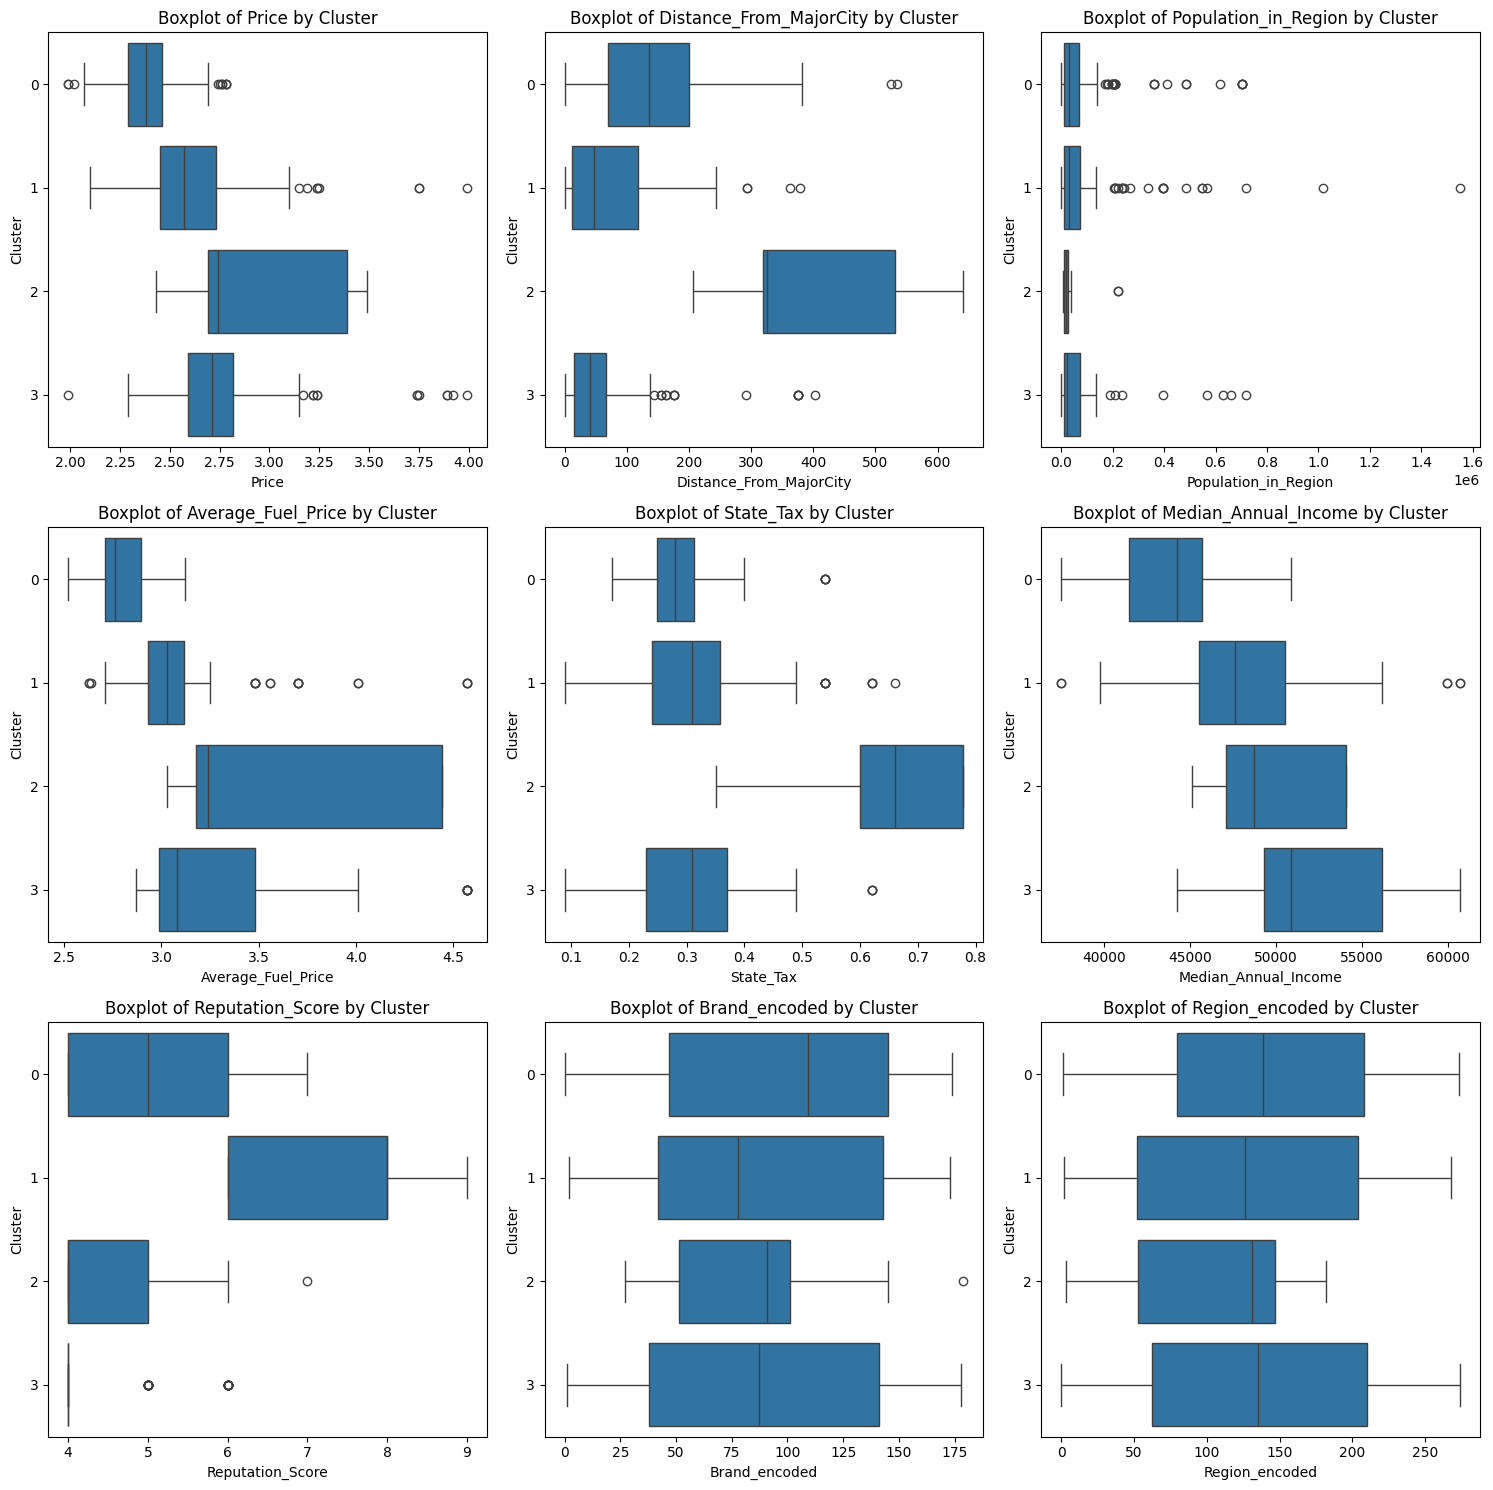

In [ ]:
numeric_vars = ['Price', 'Distance_From_MajorCity', 'Population_in_Region', 'Average_Fuel_Price', 'State_Tax', 'Median_Annual_Income', 'Reputation_Score', 'Brand_encoded', 'Region_encoded']

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, var in enumerate(numeric_vars):
    sns.boxplot(x=var, y='Cluster', data=df_extended, orient='h', ax=axes[i])
    axes[i].set_title(f'Boxplot of {var} by Cluster')

for ax in axes[len(numeric_vars):]:
    ax.set_visible(False)
# Adjust layout
plt.tight_layout()
plt.show()
